In [2]:
#Math Part
import numpy as np
import pandas as pd
import time

#Graph
import matplotlib.pyplot as plt

import importlib
import circuit
import encoding
import qsvm
import fitness
import gsvm
importlib.reload(circuit)
importlib.reload(encoding)
importlib.reload(qsvm)
importlib.reload(fitness)
importlib.reload(gsvm)

<module 'gsvm' from 'c:\\Users\\londh\\qc\\Automatic_design_of_quantum_feature_maps_Genetic_Auto-Generation-main\\Qkrishi---QSVM\\gsvm.py'>

In [4]:
nqubits = 5
depth = 7
output="bank_testdata_note.csv"
df = pd.read_csv('bank_cleaned.csv')

bank_data = df.sample(n=2000,random_state=1)
#bank_data = np.around(bank_data)

y = bank_data['y'].values
X = bank_data[['age','job','marital','education','default','balance','housing','loan','contact',
              'day','month','duration','campaign','pdays','previous','poutcome']].values
start = time.time()

pop, pareto, logbook = gsvm.gsvm(nqubits=nqubits, depth=depth, nparameters=3,
                                    X=X, y=y, weights=[-1.0,1.0],
                                    mu=10,lambda_=5,ngen=5,mutpb=0.3,cxpb=.7,debug=False)

print(f'Simulation finished after {time.time()-start} seconds')

print(f'\nGenetic-algorithm output ({output})')
print('---------------------------------------------')
with open(output, "w") as f:
    for ide, ind in enumerate(pareto):
        genes=''.join(str(i) for i in list(ind))
        gates, acc = ind.fitness.values
        line = f'{ide},"{genes}",{gates},{acc}'
        f.write(line)
        f.write('\n')
        print(line)

d:\Anaconda\envs\qc\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
d:\Anaconda\envs\qc\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


   	      	                       acc                       	                       wc                       
   	      	-------------------------------------------------	------------------------------------------------
gen	nevals	gen	max 	media  	min 	nevals	std      	gen	max    	media  	min   	nevals	std     
0  	10    	0  	0.71	0.62975	0.57	10    	0.0492881	0  	8.12033	7.17353	5.2769	10    	0.833086
1  	5     	1  	0.71	0.64825	0.6 	5     	0.0375342	1  	7.82406	6.74443	5.2769	5     	0.892566
2  	5     	2  	0.71	0.6565 	0.5875	5     	0.0382459	2  	7.82406	6.68353	5.2769	5     	0.942909
3  	5     	3  	0.71	0.6535 	0.5875	5     	0.0382459	3  	7.71173	6.60592	5.2769	5     	0.875361
4  	5     	4  	0.71	0.6565 	0.6125	5     	0.0338785	4  	7.71173	6.53822	4.9727	5     	0.967972
5  	5     	5  	0.71	0.6495 	0.57  	5     	0.0426585	5  	7.71173	6.33689	4.9727	5     	1.04715 
Simulation finished after 6.03739857673645 seconds

Genetic-algorithm output (bank_testdata_note.csv)
-------------------

In [5]:
iot_result = pd.read_csv('bank_testdata.csv',header=None)

def ordenar_salidas_pareto(dataframe):
    dataframe.columns=['ind','circ','gates','accuracy']
    dataframe.sort_values(['gates','accuracy'], ascending=[False,False],inplace=True)
    dataframe.reset_index(inplace=True)
    dataframe.pop('index')
    return dataframe

iot_salidas = ordenar_salidas_pareto(iot_result)
iot_salidas # Queremos ver el primer circuito del dataframe yya ordenado por accuracy (mejor ind)

,ind,circ,gates,accuracy
0,10,0101111001101110100001101110001111001011010000...,7.951297,0.815
1,9,0110000000110010111101001110110010110100101111...,6.195556,0.800
2,8,0110101011010101101000000000111100010111110000...,5.718756,0.780
3,7,0110101011010101101000000000110001001001010000...,5.555556,0.750
4,6,0100101001101110101101100110101101001011110000...,5.398756,0.720
5,5,0110101011010101101000000000111100010111110000...,5.272978,0.695
6,4,0110101011010101101000000000111100010111110000...,4.874667,0.680
7,3,0100101001101110101101100110101101001011110000...,4.785333,0.660
8,2,0100101001101110101101100110101101001011110000...,4.583611,0.650
9,1,0100101001101110101101100100111100010111110000...,4.248075,0.645


['01011', '11001', '10111', '01000', '01101', '11000', '11110', '01011', '01000', '01000', '10100', '01010', '01111', '10111', '00001', '00011', '00011', '11110', '01110', '00100', '11000', '00101', '01011', '11001', '01000', '11010', '10101', '10011', '11111', '01011', '11100', '10001', '10001', '01000', '01011', '10010', '11001', '01001', '00101', '11110', '10010', '10010', '11010', '10000', '01011', '01001', '10010', '01000', '10110', '01010', '11111', '11100', '11000', '00010', '10100', '11110', '01001', '00100', '00000', '10101', '01111', '00011', '00111', '11101', '01000', '01001', '11000', '00110', '11110', '10011', '01100', '01100']
43.0


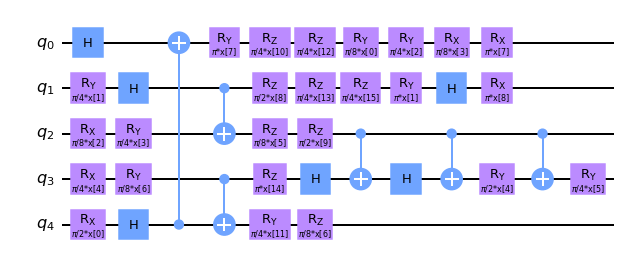

In [6]:
from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit import QuantumRegister

def coding_bits(b):
    c = [b[n:n+5] for n,i in enumerate(b) if n%5==0]
    c_p=[]
    coding_0=[]
    for i in range(len(c)):
        for j in c[i]:
            c_p.append(str(j))
    np.asarray(c_p)
    c = [c_p[n:n+5] for n,i in enumerate(c_p) if n%5==0]
    for i in c:
        coding_0.append(''.join(i))
    return coding_0

class CircuitConversor:

    def __init__(self, nqubits, nparameters):
        gates = {}
        for n, suffix in enumerate(['00','01','10','11']):
            angle = np.pi / (2**n)
            gates['000'+suffix] = (self.make_H(), 1.0)
            gates['001'+suffix] = (self.make_cx(), 2.0)
            gates['010'+suffix] = (self.make_id(), 0.0)
            gates['011'+suffix] = (self.make_rx(angle), 1.0)
            gates['100'+suffix] = (self.make_rz(angle), 1.0)
            gates['101'+suffix] = (self.make_id(), 0.0)
            gates['110'+suffix] = (self.make_id(), 0.0)
            gates['111'+suffix] = (self.make_ry(angle), 1.0)
        self.gates = gates
        self.nqubits = nqubits
        self.register = QuantumRegister(nqubits, 'q')
        self.nparameters = nparameters
        self.nqubits = nqubits
        self.x = ParameterVector('x', nparameters)

    def __call__(self, coding_0):
        print(coding_0)
        circuit = QuantumCircuit(self.register)
        k = 0
        cost = 0
        for ndx, z in enumerate(coding_0):
            qubit = ndx % self.nqubits
            target = (ndx + 1) % self.nqubits
            fn, weight = self.gates[z]
            k = fn(circuit, k, qubit, target)
            cost += weight
        for i in range(k, self.nparameters):
            circuit.rz(self.x[i]*0, self.register[0])
        return circuit, cost

    def make_id(self):
        def operation(circuit, k, qubit, target):
            return k
        return operation

    def make_H(self):
        def operation(circuit, k, qubit, target):
            circuit.h(self.register[qubit])
            return k
        return operation

    def make_cx(self):
        def operation(circuit, k, qubit, target):
            circuit.cx(self.register[qubit], self.register[target])
            return k
        return operation

    def make_rx(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rx(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

    def make_ry(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.ry(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

    def make_rz(self, angle):
        def operation(circuit, k, qubit, target):
            circuit.rz(self.x[k%self.nparameters] * angle,
                       self.register[qubit])
            return k+1
        return operation

cc = CircuitConversor(nqubits=nqubits, nparameters=16)
fm, puertas = cc(coding_bits(iot_salidas.circ[0]))
print(puertas)
fm.draw(output='mpl')

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, accuracy_score
import matplotlib.pyplot as plt

In [13]:
def featuremap_performance(pop:str,nqubits:int) -> None:
    '''Returns the performance of a feature map on all of the dataset'''
    df_1 = df.sample(frac=1)
    for i in range(8):
        if i == 7:
            bank_data = df_1.iloc[70000:79844]
        bank_data = df_1.iloc[i*10000:i*10000+10000]

        y = bank_data['y'].values
        X = bank_data[['age','job','marital','education','default','balance',
                    'housing','loan','contact','day','month','duration','campaign','pdays','previous','poutcome']].values

        fitness_obj = fitness.Fitness(nqubits,16,X,y,debug=True)

        training_features, training_labels, test_features, test_labels = fitness.Dataset(X,y)

        model = qsvm.QSVM(lambda parameters: fitness_obj.cc(pop, parameters)[0],training_features,training_labels)

        y_pred = model.predict(test_features)

        cm = confusion_matrix(test_labels, y_pred)

        ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)
        plt.show()
        recall = recall_score(test_labels, y_pred)
        acc  = accuracy_score(test_labels, y_pred)
        line = f'Accuracy = {acc}, Recall = {recall} for {i+1}th section of the data'
        print(line)
    
    return None

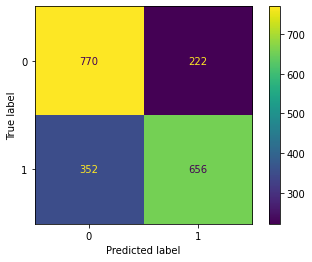

Accuracy = 0.713, Recall = 0.6507936507936508 for 1th section of the data


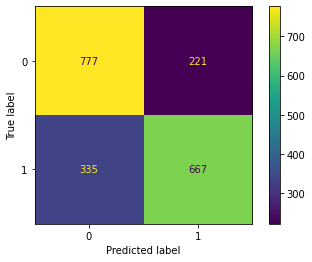

Accuracy = 0.722, Recall = 0.6656686626746507 for 2th section of the data


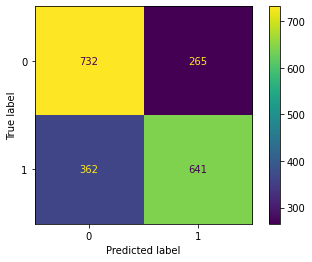

Accuracy = 0.6865, Recall = 0.6390827517447657 for 3th section of the data


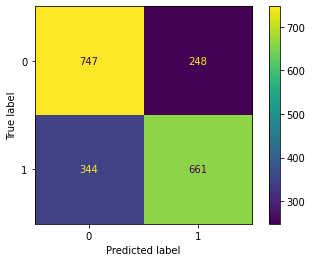

Accuracy = 0.704, Recall = 0.6577114427860696 for 4th section of the data


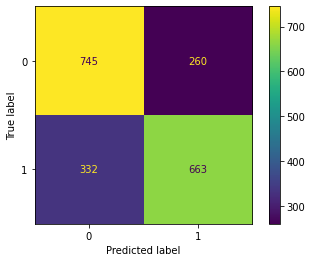

Accuracy = 0.704, Recall = 0.6663316582914572 for 5th section of the data


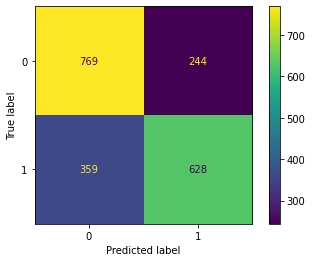

Accuracy = 0.6985, Recall = 0.6362715298885512 for 6th section of the data


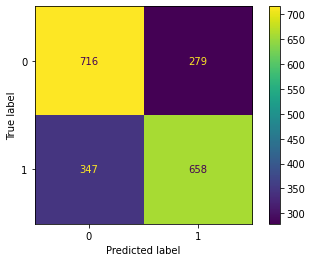

Accuracy = 0.687, Recall = 0.6547263681592039 for 7th section of the data


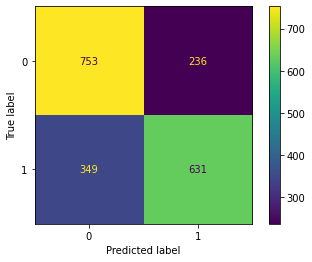

Accuracy = 0.7028948704926359, Recall = 0.6438775510204081 for 8th section of the data


In [14]:
featuremap_performance(iot_salidas.circ[0],nqubits)

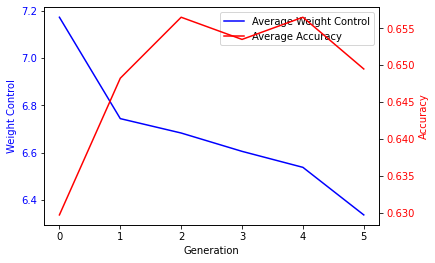

<Figure size 600x400 with 0 Axes>

In [10]:
gen = logbook.select("gen")
wc = logbook.chapters["wc"].select("media")
acc = logbook.chapters["acc"].select("media")

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
plt.figure(dpi = 100)
line1 = ax1.plot(gen, wc ,"b-", label="Average Weight Control")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Weight Control", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")

ax2 = ax1.twinx()
line2 = ax2.plot(gen, acc, "r-", label="Average Accuracy")
ax2.set_ylabel("Accuracy", color="r")
for tl in ax2.get_yticklabels():
    tl.set_color("r")

lns = line1 + line2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="best")

plt.show()